# Facebook Message Analyzer

<b> Current Features For a Given Chat: </b>
<ul> 
    <li> Number of Messages Sent </li> 
    <li> Messages Sent Over Time </li> 
    <li> Average Word Count </li>
</ul>

In [34]:
import os
import json
import numpy as np
import pylab as pl
import datetime

CURRENT_DIRECTORY = os.getcwd()
NUMBER_TO_ANALYZE = 5000
MESSAGE_THRESHOLD = 10
MESSAGE_BOUND = 1000

In [35]:
def get_json_data(chat):
    try:
        json_location = CURRENT_DIRECTORY + "/messages/" + chat + "/message.json"
        with open(json_location) as json_file:
            json_data = json.load(json_file)
            return json_data
    except IOError:
        pass # some things the directory aren't messages (DS_Store, stickers_used, etc.)

In [36]:
chats = os.listdir(CURRENT_DIRECTORY + "/messages/")[:NUMBER_TO_ANALYZE]
sorted_chats = []
final_data_messages = {}
final_data_times = {}
final_data_words = {}
invalid_message_count = 0

In [37]:
print('Analyzing ' + str(min(NUMBER_TO_ANALYZE, len(chats))) + ' chats...')

for chat in chats:
    url = chat + '/message.json'
    json_data = get_json_data(chat)
    print(chat)
    if json_data != None:
        messages = json_data["messages"]
        if len(messages) >= MESSAGE_THRESHOLD and len(messages) <= MESSAGE_BOUND:
            sorted_chats.append((len(messages), chat, messages))

sorted_chats.sort(reverse=True)

print('Finished processing chats...')

Analyzing 7 chats...
.DS_Store
kevindillon_f6193ac9b8
Catappreciationchat_89e0d454d9
kaialangathianos_95580a3269
adamdonnelly_8f40ea0790
Indoorsoccer_ea14b34757
michaelwernig_1089dcbaf3
Finished processing chats...


In [38]:
emo_array = []
names = []
time_array = []
number_gaps = 0
# iterates through folders
for i, (messages, chat, messages) in enumerate(sorted_chats):
    number_messages = {}
    person_to_times = {}
    number_words = {}

    print(str(i) + " - " + str(len(messages)) + " messages - " + str(chat))
    
    names.append(str(chat))
    bang_count = 0.0
    cap_count = 0.0
    character_count = 0.0
    bang_index = 0.0
    cap_index = 0.0
    emo_index = 0.0
    
    person_times = []
    # iterates through individual messages within each file
    for message in messages:
        try:
            name = message["sender_name"]
            time = message["timestamp_ms"]
            message_content = message["content"]

            number_messages[name] = number_messages.get(name, 0)
            number_messages[name] += 1
            new_time = time
            
            person_times.append(new_time)
            
            # counts the number of bangs and capitalizations
            count = 0
            while count < len(message_content) - 1:
                if message_content[count] == '!':
                    bang_count += 1
                elif message_content[count].isupper():
                    cap_count += 1
                count += 1
                character_count += 1
                
            person_to_times[name] = person_to_times.get(name, [])
            person_to_times[name].append(datetime.datetime.fromtimestamp(time/1000.0))

            number_words[name] = number_words.get(name, [])
            number_words[name].append(len(message_content.split()))
        except KeyError:
            # happens for special cases like users who deactivated, unfriended, blocked
            invalid_message_count += 1
            
    counter = 0
    gap_time = 0
    # takes the average amount of time between messages in miliseconds
    # then appends that average to an array with each index representing a person
    for i in range(1, len(person_times)):
        gap_time += person_times[i] - person_times[i - 1]
        counter += 1
    gap_time = gap_time / counter
    time_array.append(abs(gap_time) * 0.001 / 84000)
    
    # creates the emotional index by taking the amount of capitalizations
    # and bangs used per character for each person
    bang_index = bang_count / character_count
    cap_index = cap_count / character_count
    emo_index = (cap_index + bang_index) * 1000
    emo_index_int = 0
    emo_index_int = round(emo_index)
    int(emo_index_int)
    emo_array.append(emo_index_int)

    final_data_messages[i] = number_messages
    final_data_times[i] = person_to_times
    final_data_words[i] = number_words

print('Found ' + str(invalid_message_count) + ' invalid messages...')
print('Found ' + str(len(sorted_chats)) + ' chats with ' + str(MESSAGE_THRESHOLD) + ' messages or more')

0 - 497 messages - Indoorsoccer_ea14b34757
1 - 121 messages - michaelwernig_1089dcbaf3
2 - 108 messages - kaialangathianos_95580a3269
3 - 53 messages - adamdonnelly_8f40ea0790
Found 1 invalid messages...
Found 4 chats with 10 messages or more


In [39]:
def plot_num_messages(chat_number):
    plotted_data = final_data_messages[chat_number]
    X = np.arange(len(plotted_data))
    pl.bar(X, list(plotted_data.values()), align='center', width=0.5, color = 'r', bottom = 0.3)
    pl.xticks(X, plotted_data.keys(), rotation = 90)
    pl.title('Number of Messages Sent')
    pl.tight_layout()
    pl.show()
    
def plot_histogram_time(chat_number):
    person_to_times = final_data_times[chat_number]
    pl.xlabel('Time')
    pl.ylabel('Number of Messages')
    pl.title('# of Messages Over Time')
    colors = ['b', 'r', 'c', 'm', 'y', 'k', 'w', 'g']
    for i , person in enumerate(person_to_times):
        plotted_data = person_to_times[person]
        pl.hist(plotted_data, 100, alpha=0.3, label=person, facecolor=colors[i % len(colors)])
    pl.legend()
    pl.xticks(rotation=90)
    pl.tight_layout()
    pl.show()
    
def plot_emo_index(chat_number):
    left = np.arange(len(names))
    pl.bar(left, emo_array)
    pl.xlabel('Names', fontsize=5)
    pl.ylabel('AEI (Arbitrary Emotional Index', fontsize=5)
    pl.xticks(left, names, fontsize=5, rotation=30)
    pl.title('How emotional conversations are with certain people')
    pl.show()
    
def plot_time_array(chat_number):
    left = np.arange(len(names))
    pl.bar(left, time_array)
    pl.xlabel('Names', fontsize=10)
    pl.ylabel('Average Amount of Days You Take to Respond to Each Person', fontsize=10)
    pl.xticks(left, names, fontsize=10, rotation=30)
    pl.title('Time to Respond')
    pl.show()
    
def plot_histogram_words(chat_number):
    temp = {}
    for person in final_data_words[chat_number]:
        temp[person] = np.average(final_data_words[chat_number][person])
    plotted_data = temp
    X = np.arange(len(plotted_data))
    pl.bar(X, list(plotted_data.values()), align='center', width=0.5, color = 'r', bottom = 0.3)
    pl.xticks(X, plotted_data.keys(), rotation = 90)
    pl.title('Average Word Count')
    pl.tight_layout()
    pl.show()
    
def plot(chat_number):
    plot_num_messages(chat_number)
    plot_histogram_time(chat_number)
    plot_histogram_words(chat_number)

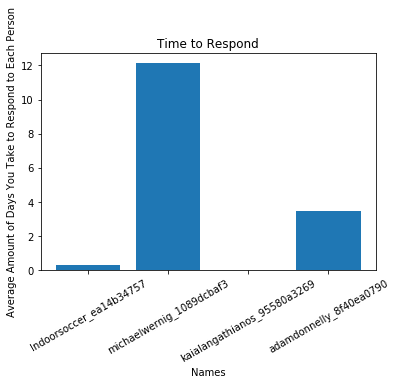

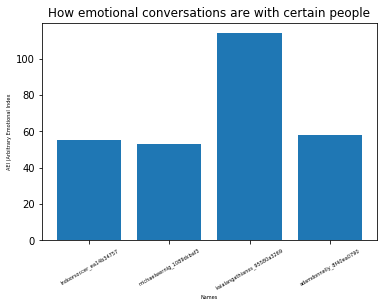

In [40]:
plot_time_array(0)
plot_emo_index(0)